In [1]:
import random

Now we create the main classes of the simulation. Membrane() represents the membrane where the radnom walk of molecules take place, Position() is a position of this membrane and Receptor() is the GPCR we want to move.

In [2]:
class Membrane(object):
    """ creates a membrane (width x height) of hexagons"""
    def __init__(self, width, height):
        self.width = width
        self.height = height #must be even for correct coordinates!!!!
        self.room = []
        for x in range(self.width):
            room_x=[]
            for y in range(self.height):
                room_x.append('-')
            self.room.append(room_x)

    def __str__(self):
        for y in range(self.height-1, -1, -1):
            if y%2 == 1:
                print '  ',
            for x in range(self.width):
                if self.room[x][y] == '-':
                    print ' ' ,self.room[x][y], ' ',
                else:
                    print ' ' ,self.room[x][y].a_or_d, ' ',
            print ' '
            print ' '
        return ''

    def getRandomPos(self):
        """returns a random position of the membrane"""
        x = random.choice(range(self.width))
        y = random.choice(range(self.height))
        return Position(x,y)

In [3]:
class Position(object):

    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __str__(self):
        return str(self.getX()) + ' ' + str(self.getY())
    
    def getX(self):
        return self.x
    
    def getY(self):
        return self.y

    def convert_pos(self, membrane):
        """ applys the concept of periodic boundry condition:
        if the position is out of the membrane, creates a new position at the oposite side of membrane"""
        if self.x<0:
            self.x = self.x + membrane.width
        if self.x>membrane.width-1:
            self.x = self.x - membrane.width
        if self.y<0:
            self.y = self.y + membrane.height
        if self.y>membrane.height-1:
            self.y = self.y - membrane.height

    def get_neighbour_pos(self, membrane):
        """ returns the coordinates of the neighbourous positions as a list"""
        neighbour_pos = []
        if self.getY()%2 == 0:
            for i in [(0,1),(1,0),(0,-1),(-1,-1),(-1,0),(-1,1)]:
                x = self.getX() + i[0]
                y = self.getY() + i[1]
                new_pos = Position(x,y)
                new_pos.convert_pos(membrane)
                neighbour_pos.append(new_pos)
        else:
            for i in [(1,1),(1,0),(1,-1),(0,-1),(-1,0),(0,1)]:
                x = self.getX() + i[0]
                y = self.getY() + i[1]
                new_pos = Position(x,y)
                new_pos.convert_pos(membrane)
                neighbour_pos.append(new_pos)
        return neighbour_pos

    def are_neighbours(self, pos, membrane):
        """ returns True if the two positions are neighbours, else return False"""
        pos_list = self.get_neighbour_pos(membrane)
        for i in pos_list:
            if i.getX() == pos.getX() and i.getY() == pos.getY():
                return True
        else:
            return False

In [9]:
class Receptor(object):
    """ creates a receptor, in a membrane. The receptor can be 'D'(onor) or 'A'(cceptor)
    paon, pdon, paoff, pdoff represents the probability of dimerization (on) or
    monomeization (off) with an acceptor (a) or donor(d). Donor receptors have
    an rluc luminsecence (rluc) and yfp luminescence vaue. Receptor is positioned
    into a random, not occupied hexa of the membrane"""
    def __init__(self, membrane, a_or_d, paon, pdon, paoff, pdoff):
        self.membrane = membrane
        self.a_or_d = a_or_d
        self.paon = paon
        self.pdon = pdon
        self.paoff = paoff
        self.pdoff = pdoff
        self.dimer = '-'
        self.has_moved = False                  #hasn't moved in this iteration
        self.has_changed_dimer_status = False   #hasn't changed dimer status in this iteration
        if self.a_or_d == 'D':
            self.rluc = 1.0
            self.yfp = 0.0
            self.bret = self.yfp / self.rluc
        occupied = True
        while occupied:
            self.pos = self.membrane.getRandomPos()
            if self.membrane.room[self.pos.getX()][self.pos.getY()] == '-':
                occupied = False
        self.membrane.room[self.pos.getX()][self.pos.getY()] = self

    def get_free_neighbour_pos(self):
        """returns a free neighbour position in a list"""
        neighbour_pos = self.pos.get_neighbour_pos(self.membrane)
        free_neighbour_pos = []
        for i in neighbour_pos:
            if self.membrane.room[i.getX()][i.getY()] == '-':
                free_neighbour_pos.append(i)
        return free_neighbour_pos

    def get_neighbours(self):
        """return the neighbouring receptors in a list"""
        neighbour_pos = self.pos.get_neighbour_pos(self.membrane)
        neighbours = []
        for i in neighbour_pos:
            if self.membrane.room[i.getX()][i.getY()] != '-':
                neighbours.append(self.membrane.room[i.getX()][i.getY()])
        return neighbours
    
    def get_free_neighbour_pos_dimer(self):
        """return the free neighbouring positions of a dimer"""
        neighbour_pos_self = self.pos.get_neighbour_pos(self.membrane)
        neighbour_pos_pair = self.dimer.pos.get_neighbour_pos(self.dimer.membrane)
        free_neighbour_pos = []
        for i in neighbour_pos_self:
            if self.membrane.room[i.getX()][i.getY()] == '-' or self.membrane.room[i.getX()][i.getY()] == self.dimer:
                for j in neighbour_pos_pair:
                    if self.dimer.membrane.room[j.getX()][j.getY()] == '-' or self.dimer.membrane.room[j.getX()][j.getY()] == self:
                        if i.are_neighbours(j,self.membrane):
                            free_neighbour_pos.append([i,j])                  
        return free_neighbour_pos
                                                                         
    def move(self):
        if self.has_moved == False:
            if self.dimer == '-':
                free_neighbour_pos=self.get_free_neighbour_pos()
                self.membrane.room[self.pos.getX()][self.pos.getY()] = '-'
                if len(free_neighbour_pos)>0:
                    self.pos=random.choice(free_neighbour_pos)
                self.membrane.room[self.pos.getX()][self.pos.getY()] = self
                self.has_moved = True
            elif self.dimer.has_moved == False:
                free_neighbour_pos = self.get_free_neighbour_pos_dimer()
                self.membrane.room[self.pos.getX()][self.pos.getY()] = '-'
                self.dimer.membrane.room[self.dimer.pos.getX()][self.dimer.pos.getY()] = '-'
                if len(free_neighbour_pos)>0:
                    new_pos = random.choice(free_neighbour_pos)
                    self.pos = new_pos[0]
                    self.dimer.pos = new_pos[1]
                self.membrane.room[self.pos.getX()][self.pos.getY()] = self
                self.dimer.membrane.room[self.dimer.pos.getX()][self.dimer.pos.getY()] = self.dimer
                self.has_moved = True
                self.dimer.has_moved = True

    def change_dimer_status(self):
        if self.has_changed_dimer_status == False:
            if self.dimer == '-':
                neighbours = self.get_neighbours()
                for i in neighbours:
                    if i.has_changed_dimer_status == False:
                        x = random.random()
                        if i.a_or_d == 'A':
                            p=self.paon
                        if i.a_or_d == 'D':
                            p=self.pdon
                        if x<p:
                            self.dimer = i
                            self.dimer.dimer = self
                            self.has_changed_dimer_status = True
                            self.dimer.has_changed_dimer_status = True
                            break
            else:
                if self.dimer.has_changed_dimer_status == False:
                    x=random.random()
                    if self.dimer.a_or_d == 'A':
                        p=self.paoff
                    if self.dimer.a_or_d == 'D':
                        p=self.pdoff
                    if x<p:
                        self.has_changed_dimer_status = True
                        self.dimer.has_changed_dimer_status = True
                        self.dimer.dimer = '-'
                        self.dimer = '-'

    def get_bret(self):
        if self.a_or_d == 'D':
            self.rluc = 1.0
            self.yfp = 0.4
            neighbours = self.get_neighbours()
            for i in neighbours:
                if i.a_or_d == 'A':
                    self.yfp = self.yfp + 0.2
                    self.rluc = self.rluc - 0.05
            self.bret=self.yfp/self.rluc         

In [10]:
def calculate_bret(rlist):
    bret = 0
    d = 0
    for i in rlist:
        i.get_bret()
    for i in rlist:
        if i.a_or_d == 'D':
            bret+=i.bret
            d+=1
    return bret/d

Now let's have some Graphical demo of what our script does. It creates a small membrane with 1 donor and 1 acceptor, and moves them with each ENTER. One can quit with 's' key. A(cceptor) and D(onor) have in this demo p_dimerize==1, so when they get into neighbouring places, they will stay together. Also important, that our Membrane() has periodic boundry conditions, so when something "leaves" at the right / top side, it comes back left / bottom, respecrtively.

In [11]:
def graphics_demo():
    """ graphical demo with one donor and one acceptor, with pdimerization=1.0
    ends with 's' key"""
    mem = Membrane(6,6)
    rlist = []
    print mem
    for i in range(1):
        rlist.append(Receptor(mem,'A',0.0,1.0,0.0,0.0))
        rlist.append(Receptor(mem,'D',1.0,0.0,0.0,0.0))
    print mem
    while raw_input()!='s':
        print mem
        for i in rlist:
            i.has_moved=False
            i.has_changed_dimer_status=False
        for i in rlist:
            i.move()
        for i in rlist:
            i.change_dimer_status()

In [7]:
graphics_demo()

     -     -     -     -     -     -    
 
  -     -     -     -     -     -    
 
     -     -     -     -     -     -    
 
  -     -     -     -     -     -    
 
     -     -     -     -     -     -    
 
  -     -     -     -     -     -    
 

     -     -     -     -     -     -    
 
  -     D     -     -     -     -    
 
     -     -     -     -     -     A    
 
  -     -     -     -     -     -    
 
     -     -     -     -     -     -    
 
  -     -     -     -     -     -    
 

s


Now do our simulation with d donor, a acceptor, pddon donor-donor association probability, pddoff donor-donor dissociation probabilty, pdaoon donor-acceptor association probability, pdaoff donor-acceptoy dissociation probability, paaon acceptor-acceptor assocaiation and paaoff acceptor-acceptor dissociation probability. Our Membrane is 100x100 hexagons. In our first simulation nothing dimerises (all probabilities are 0).

In [6]:
d,a,pddon,pddoff,pdaon,pdaoff,paaon,paaoff = [100,100,0.0,0.0,0.0,0.0,0.0,0.0]

In [12]:
def simulate(d,a,pddon,pddoff,pdaon,pdaoff,paaon,paaoff):
    """ d: number of donors
        a: number of acceptors
        pddon: donor-donor association probability
        pddoff: donor-donor dissociation probability
        pdaon: donor-acceptor association probability
        pdaoff: donor-acceptor dissociation probability
        paaon: acceptor-acceptor association probability
        paaoff: acceptor-acceptor dissociation probability
        
        performs simulation for 1000 iterations, returns bret"""
    
    mem = Membrane(100,100)
    rlist = []
    for j in range(d):
        rlist.append(Receptor(mem, 'D', pdaon, pddon, pdaoff, pddoff))
    for j in range(a):
        rlist.append(Receptor(mem, 'A', paaon, pdaon, paaoff, pdaoff))
    for j in range(1000):
        for k in rlist:
            k.has_moved = False
            k.has_changed_dimer_status = False
        for k in rlist:
            k.move()
        for k in rlist:
            k.change_dimer_status()
    return calculate_bret(rlist)   

In [13]:
bret=simulate(d,a,pddon,pddoff,pdaon,pdaoff,paaon,paaoff)

In [11]:
bret

0.4118362573099408

Let us make some simulation where number of donors is either 100 or 500, and acceptor is 100, 200, 500 and 1000. There is still no dimerization.

In [22]:
bret_donor100=[]
bret_donor500=[]
for a in [100,200,500,1000]:
    bret_donor100.append(simulate(100,a,pddon,pddoff,pdaon,pdaoff,paaon,paaoff))
    bret_donor500.append(simulate(500,a,pddon,pddoff,pdaon,pdaoff,paaon,paaoff))

Let's make some plot: X axis is number of acceptors, Y axis is the calculated BRET. The color of the points is the dependent on the number of donors (100 or 500). The calculated BRET is 0.4 at baseline, so we will plot BRET-0.4 (it is common in BRET experiments, that the baseline signal is non 0). As we did not had dimerization in this simulation setup, we wait a lineal relationship between acceptor and BRET, and no effect of donor number.

In [23]:
bret_donor100=list(np.array(bret_donor100)-0.4)
bret_donor500=list(np.array(bret_donor500)-0.4)

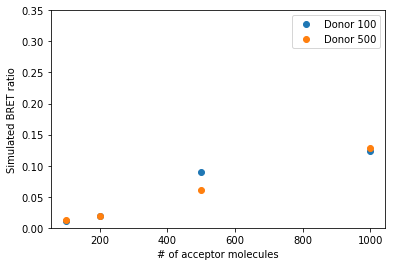

In [25]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot([100,200,500,1000],bret_donor100,'o')
plt.plot([100,200,500,1000],bret_donor500,'o')
plt.xlabel('# of acceptor molecules')
plt.ylabel('Simulated BRET ratio')
plt.legend(['Donor 100','Donor 500'])
plt.ylim(0,0.35)
plt.show()

We can also plot the BRET ratio as a function of acceptor / donor ratio.

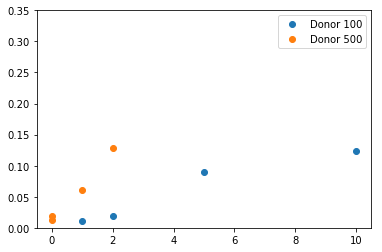

In [26]:
plt.plot(np.array([100,200,500,1000])/100,bret_donor100,'o')
plt.plot(np.array([100,200,500,1000])/500,bret_donor500,'o')
plt.legend(['Donor 100','Donor 500'])
plt.xlabel('Acceptor / Donor ratio')
plt.ylabel('Simulated BRET ratio')
plt.ylim(0,0.35)
plt.show()

If donor and acceptor can dimerize (pdaon=1.0 and pdaoff=0.0, meaning when they dimerize, they remain together), and run the simulation again, we get curve similar to the "specific interaction" from the manuscript. (this simulation is rather slow)

In [27]:
pddon,pddoff,pdaon,pdaoff,paaon,paaoff = [0.0,0.0,1.0,0.0,0.0,0.0]
bret_donor100=[]
bret_donor500=[]
for a in [100,200,500,1000]:
    bret_donor100.append(simulate(100,a,pddon,pddoff,pdaon,pdaoff,paaon,paaoff))
    bret_donor500.append(simulate(500,a,pddon,pddoff,pdaon,pdaoff,paaon,paaoff))

In [28]:
bret_donor100=list(np.array(bret_donor100)-0.4)
bret_donor500=list(np.array(bret_donor500)-0.4)

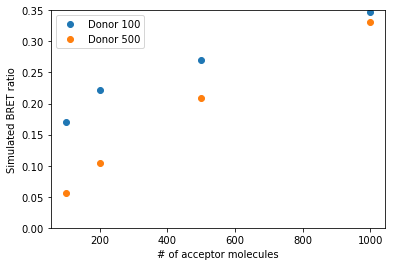

In [31]:
plt.plot([100,200,500,1000],bret_donor100,'o')
plt.plot([100,200,500,1000],bret_donor500,'o')
plt.legend(['Donor 100','Donor 500'])
plt.ylabel('Simulated BRET ratio')
plt.xlabel('# of acceptor molecules')
plt.legend(['Donor 100','Donor 500'])
plt.ylim(0,0.35)
plt.show()

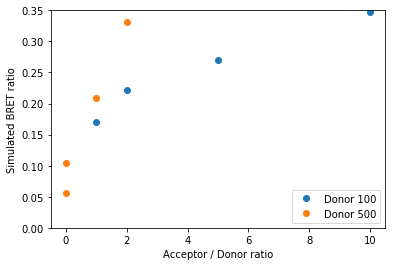

In [32]:
plt.plot(np.array([100,200,500,1000])/100,bret_donor100,'o')
plt.plot(np.array([100,200,500,1000])/500,bret_donor500,'o')
plt.legend(['Donor 100','Donor 500'])
plt.xlabel('Acceptor / Donor ratio')
plt.ylabel('Simulated BRET ratio')
plt.ylim(0,0.35)
plt.show()

In [33]:
bret_specific=[]
bret_nonspecific=[]
for a in [100,200,500,700,900]:
    pddon,pddoff,pdaon,pdaoff,paaon,paaoff = [0.0,0.0,1.0,0.0,0.0,0.0]
    bret_specific.append(simulate(1000-a,a,pddon,pddoff,pdaon,pdaoff,paaon,paaoff))
    pddon,pddoff,pdaon,pdaoff,paaon,paaoff = [0.0,0.0,0.0,0.0,0.0,0.0]
    bret_nonspecific.append(simulate(1000-a,a,pddon,pddoff,pdaon,pdaoff,paaon,paaoff))

In [39]:
bret_specific=list(np.array(bret_specific)-0.4)
bret_nonspecific=list(np.array(bret_nonspecific)-0.4)

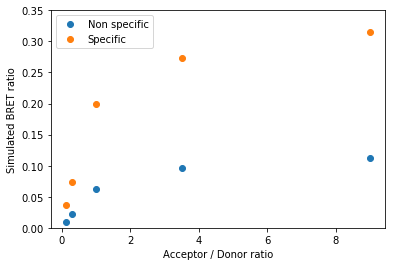

In [41]:
plt.plot(np.array([100.0,200.0,500.0,700.0,900.0])/np.array([900,700,500,200,100]),bret_nonspecific,'o')
plt.plot(np.array([100.0,200.0,500.0,700.0,900.0])/np.array([900,700,500,200,100]),bret_specific,'o')
plt.legend(['Non specific','Specific'])
plt.xlabel('Acceptor / Donor ratio')
plt.ylabel('Simulated BRET ratio')
plt.ylim(0,0.35)
plt.show()